**About Dataset**
**Context**
Please upvote if you find this dataset of use. - Thank you
This version is an update of the earlier version. I ran a data set quality evaluation program on the previous version which found a considerable number of duplicate and near duplicate images. Duplicate images can lead to falsely higher values of validation and test set accuracy and I have eliminated these images in this version of the dataset.
Images were gathered from internet searches. The images were scanned with a duplicate image detector program I wrote. Any duplicate images were removed to prevent bleed through of images between the train, test and valid data sets. All images were then resized to 224 X224 X 3 and converted to jpg format. A csv file is included that for each image file contains the relative path to the image file, the image file class label and the dataset (train, test or valid) that the image file resides in. This is a clean dataset. If you build a good model you should achieve at least 95% accuracy on the test set. If you build a very good model for example using transfer learning you should be able to achieve 98%+ on test set accuracy. If you find this data set useful please upvote. Thanks

**Content**
Collection of sports images covering 100 different sports.. Images are 224,224,3 jpg format. Data is separated into train, test and valid directories. Additionallly a csv file is included for those that wish to use it to create there own train, test and validation datasets.

In [21]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [22]:
!kaggle datasets download -d gpiosenka/sports-classification

sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
import zipfile
zip_ref = zipfile.ZipFile('/content/sports-classification.zip', 'r') # unziping data file
zip_ref.extractall('/content')
zip_ref.close()

In [24]:
import pandas as pd
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img,img_to_array,load_img
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import warnings
warnings.filterwarnings("ignore")

In [25]:
batch_size = 25

train_gen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1.0/255)

val_gen = ImageDataGenerator(rescale=1.0/255)

In [26]:
train_data = train_gen.flow_from_directory(
    "/content/train",
    target_size = (224,224),
    batch_size = batch_size,
    shuffle=True,
    class_mode = 'sparse'
)

val_data = train_gen.flow_from_directory(
    "/content/valid",
    target_size = (224,224),
    batch_size = batch_size,
    shuffle=True,
    class_mode = 'sparse'
)

test_data = train_gen.flow_from_directory(
    "/content/test",
    target_size = (224,224),
    batch_size = batch_size,
    shuffle=True,
    class_mode = 'sparse'
)

Found 13492 images belonging to 100 classes.
Found 500 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [29]:
mobile_net = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
)

In [30]:
def check_layers():
  for layer in mobile_net.layers:
    print(layer.name,layer.trainable)

check_layers()

input_2 True
Conv1 True
bn_Conv1 True
Conv1_relu True
expanded_conv_depthwise True
expanded_conv_depthwise_BN True
expanded_conv_depthwise_relu True
expanded_conv_project True
expanded_conv_project_BN True
block_1_expand True
block_1_expand_BN True
block_1_expand_relu True
block_1_pad True
block_1_depthwise True
block_1_depthwise_BN True
block_1_depthwise_relu True
block_1_project True
block_1_project_BN True
block_2_expand True
block_2_expand_BN True
block_2_expand_relu True
block_2_depthwise True
block_2_depthwise_BN True
block_2_depthwise_relu True
block_2_project True
block_2_project_BN True
block_2_add True
block_3_expand True
block_3_expand_BN True
block_3_expand_relu True
block_3_pad True
block_3_depthwise True
block_3_depthwise_BN True
block_3_depthwise_relu True
block_3_project True
block_3_project_BN True
block_4_expand True
block_4_expand_BN True
block_4_expand_relu True
block_4_depthwise True
block_4_depthwise_BN True
block_4_depthwise_relu True
block_4_project True
block_4

In [31]:
# make function to fine tune it
def fine_tuening(target_block):
  mobile_net.trainable = True
  set_trainable = False

  for layer in mobile_net.layers:
    if layer.name == target_block:
      set_trainable = True

    if set_trainable:
      layer.trainable = True

    else:
      layer.trainable = False

fine_tuening("block_7_expand")

In [32]:
check_layers()

input_2 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [33]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [34]:
from keras.src.layers.reshaping.flatten import Flatten
# now create FC network
model = Sequential()

# add mobile net convolutation base
model.add(mobile_net)

model.add(Flatten())

#add Dense layer 1
model.add(Dense(200,activation="elu",kernel_initializer="he_normal"))
model.add(BatchNormalization())

#add Dense layer 2
model.add(Dense(150,activation="elu",kernel_initializer="he_normal"))
model.add(BatchNormalization())

#add Dense layer 3
model.add(Dense(120,activation="relu",kernel_initializer="he_normal"))
model.add(BatchNormalization())

# output layer
model.add(Dense(100,activation="softmax"))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 200)               12544200  
                                                                 
 batch_normalization_3 (Bat  (None, 200)               800       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 150)               30150     
                                                                 
 batch_normalization_4 (Bat  (None, 150)              

In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 2,
    restore_best_weights = True
)

In [37]:
# Compile Model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [38]:
#train the model
history = model.fit(
    train_data,
    epochs = 15,
    # steps_per_epoch= len(train_data),
    callbacks = [early_stopping],
    validation_data = val_data
)

Epoch 1/15
540/540 [==============================] - 213s 355ms/step - loss: 2.5102 - accuracy: 0.4971 - val_loss: 1.1557 - val_accuracy: 0.7340
Epoch 2/15
540/540 [==============================] - 177s 329ms/step - loss: 1.0228 - accuracy: 0.8282 - val_loss: 0.7445 - val_accuracy: 0.8260
Epoch 3/15
540/540 [==============================] - 179s 331ms/step - loss: 0.5711 - accuracy: 0.9076 - val_loss: 0.4470 - val_accuracy: 0.8980
Epoch 4/15
540/540 [==============================] - 178s 330ms/step - loss: 0.3513 - accuracy: 0.9471 - val_loss: 0.4137 - val_accuracy: 0.8960
Epoch 5/15
540/540 [==============================] - 181s 335ms/step - loss: 0.2219 - accuracy: 0.9692 - val_loss: 0.2866 - val_accuracy: 0.9280
Epoch 6/15
540/540 [==============================] - 184s 340ms/step - loss: 0.1673 - accuracy: 0.9755 - val_loss: 0.3057 - val_accuracy: 0.9140
Epoch 7/15
540/540 [==============================] - 179s 331ms/step - loss: 0.1290 - accuracy: 0.9792 - val_loss: 0.2569 -

In [40]:
test_evaluation = model.evaluate(test_data)
print(f"Test Loss: {test_evaluation[0]}")
print(f"Test Accuracy: {test_evaluation[1]}")

20/20 [==============================] - 6s 314ms/step - loss: 0.2162 - accuracy: 0.9380
Test Loss: 0.21621301770210266
Test Accuracy: 0.9380000233650208


In [41]:
model.save("model.h5") # saving model

<Axes: >

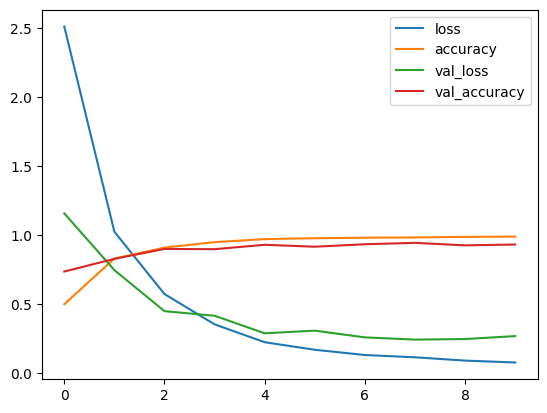

In [42]:
pd.DataFrame(history.history).plot()

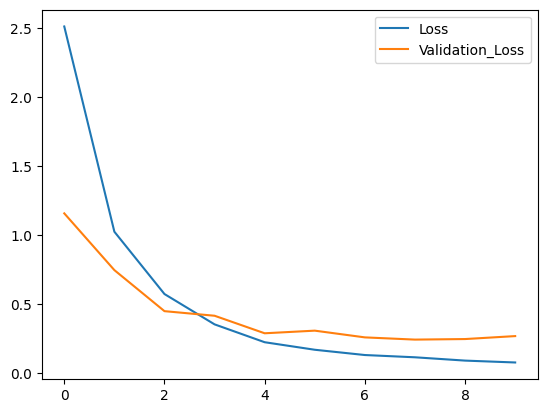

In [43]:
# plot and see the accuracy and loss
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Validation_Loss")
plt.legend()

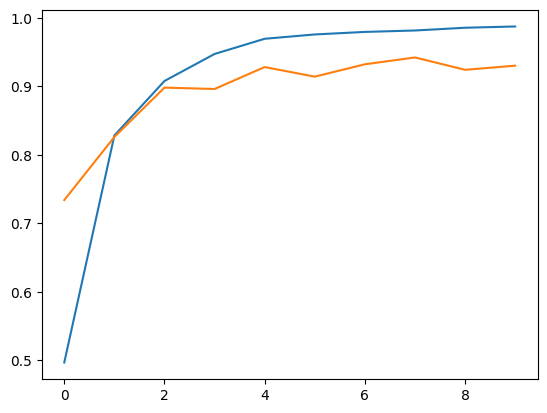

In [44]:
plt.plot(history.history["accuracy"],label="Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation_Accuracy")

In [45]:
# Set a random seed to ensure different random selections each time
np.random.seed()

# Path to your test data directory
testing_directory = '/content/test'

# Load your trained model
# model = tf.keras.models.load_model('C:\\Users\\yash mohite\\OneDrive\\Documents\\birds_classifier\\model.h5')

# List all subdirectories (bird name folders) in the testing directory
class_folders = [folder for folder in os.listdir(testing_directory) if os.path.isdir(os.path.join(testing_directory, folder))]

# Initialize a counter for the number of displayed images
displayed_images = 0

# Loop through bird name folders and select 1 random image from each
for bird_name_folder in class_folders:
    # Check if the maximum number of displayed images has been reached
    if displayed_images >= 30:
        break

    # Construct the full path to the current bird name folder
    bird_folder_path = os.path.join(testing_directory, bird_name_folder)

    # List all image files in the current bird name folder
    image_files = [f for f in os.listdir(bird_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Check if there are any images in the folder
    if len(image_files) > 0:
        # Set a new random seed for each folder to ensure different image selection
        np.random.seed()

        # Select 1 random image for testing from the current folder
        random_image_file = np.random.choice(image_files, 1)[0]
        image_path = os.path.join(bird_folder_path, random_image_file)

        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

        # Make a prediction
        prediction = model.predict(img)

        # Get the predicted class index
        predicted_class_index = np.argmax(prediction[0])

        # Get the predicted class name directly from the folder name
        predicted_class_name = bird_name_folder

        # Display the image and its label
        plt.imshow(plt.imread(image_path))
        plt.title(f"Predicted Class Index: {predicted_class_index}\nPredicted Class Name: {predicted_class_name}\nSports Name Folder: {bird_name_folder}")
        plt.axis('off')
        plt.show()

        # Increment the displayed images counter
        displayed_images += 1

Output hidden; open in https://colab.research.google.com to view.